In [1]:
from qadataset import QADataset
from config import dataset_config, model_config

MODEL_ID = "Salesforce/blip2-opt-2.7b"


train_dataset = QADataset(dataset_config, split="train[:100]")
val_dataset = QADataset(dataset_config, split="train[:10]")


/home/atomwalk12/Dropbox (Old)/notes/vision/project/BeyondVisionQA/model.py:128: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  self.metric = load_metric("bertscore")
/home/atomwalk12/anaconda3/envs/questllama/lib/python3.9/site-packages/datasets/load.py:756: FutureWarning: The repository for bertscore contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/bertscore/bertscore.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


Map:   0%|          | 0/38575 [00:00<?, ? examples/s]

Map:   0%|          | 0/38575 [00:00<?, ? examples/s]

In [2]:
from transformers import BitsAndBytesConfig, Blip2ForConditionalGeneration
import torch

## Load model

# Three options for training, from the lowest precision training to the highest precision training:
# - QLora
# - Standard Lora
# - Full fine-tuning

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.float16
)
model = Blip2ForConditionalGeneration.from_pretrained(
    MODEL_ID,
    torch_dtype=torch.float16,
    quantization_config=bnb_config,
)

`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
from torch.utils.data import Dataset, DataLoader
from trainer_blip2 import BLIP2ModelPLModule
from trainer_blip2 import BLIP2PLModule
import torch
from peft import LoraConfig, get_peft_model
from transformers import AutoProcessor, Blip2ForConditionalGeneration
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model

lora_config = LoraConfig(
    r=8,
    lora_alpha=8,
    lora_dropout=0.1,
    target_modules="all-linear",
    init_lora_weights="gaussian",
)

model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, lora_config)

In [4]:
import lightning as L
import torch
from config import dataset_config
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from torch.utils.data import DataLoader
from config import metrics
from transformers import AutoProcessor
from dataset_configs.easy_vqa import translate
from transformers import AutoProcessor
from transformers.optimization import get_cosine_schedule_with_warmup
import math
processor = AutoProcessor.from_pretrained(MODEL_ID)
processor.tokenizer.padding_side = "right" # during training, one always uses padding on the right

class BLIP2ModelPLModule(L.LightningModule):
    def __init__(self, hyperparameters, model, train_dataset, val_dataset):
        super().__init__()
        self.hyperparams = hyperparameters
        self.model = model
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset

        self.batch_size = hyperparameters.get("batch_size")

    def training_step(self, batch, batch_idx):

        inputs, labels = batch

        outputs = self.model(**inputs,
                            labels=labels)
        loss = outputs.loss
        print(f"Epoch {self.current_epoch}, loss: {loss.item()}")

        self.log("train_loss", loss, batch_size=self.batch_size)

        return loss

    def validation_step(self, batch, batch_idx, dataset_idx=0):

        inputs, answers = batch

        # auto-regressively generate token IDs

        
        generated_ids = self.model.generate(**inputs)
        # turn them back into text, chopping of the prompt
        # important: we don't skip special tokens here, because we want to see them in the output
        predictions = processor.batch_decode(generated_ids, skip_special_tokens=True)

        print(f"==================Dataset batch: {batch_idx}/{self.val_dataset.dataset_length // self.batch_size}==================")
        scores = []
        i = 0
        for pred, answer in zip(predictions, answers):
            print(f"Question: {self.val_dataset.dataset[batch_idx*self.batch_size+i]['question']}")
            print(f"Prediction: {pred}")
            print(f"Answer: {answer}")
            i += 1

        for metric in metrics:
            scores = metric.compute(predictions=predictions, references=answers, model=self)
            
        return scores

    def configure_optimizers(self):
        print(self.hyperparams)
        print("Applying both Adam and Cosine Scheduler Warmup")
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.hyperparams["lr"],
            betas=self.hyperparams['betas'],
            weight_decay=self.hyperparams['weight_decay']
        )

        # Calculate total steps based on epochs and batch size
        total_epochs = self.hyperparams['max_epochs']
        dataset_size = len(self.train_dataset)  # Assuming you have access to the dataset size
        batch_size = self.hyperparams['batch_size']
        steps_per_epoch = dataset_size // batch_size  # Integer division
        total_steps = total_epochs * steps_per_epoch


        # Convert warmup steps to warmup epochs if necessary
        warmup_epochs = self.hyperparams['warmup_epochs']
        warmup_steps = math.ceil(warmup_epochs * steps_per_epoch)
        
        print(f"Running warmup for a total of {warmup_steps} steps")

        scheduler = get_cosine_schedule_with_warmup(
            optimizer,
            num_warmup_steps=warmup_steps,
            num_training_steps=total_steps
        )
    
        return [optimizer], [scheduler]
        


class BLIP2PLModule(BLIP2ModelPLModule):
    
    def __init__(self, config, model, train_dataset, val_dataset):
        super().__init__(config, model, train_dataset, val_dataset)
    
    def train_numeric_labels(examples):
        images = []
        texts = []
        batch_labels = []
        for example in examples:
            image, ground_truth = example
            input, label = translate(ground_truth, training=True)
            
            images.append(image)
            texts.append(input)
            batch_labels.append({ 'label_ids': label['label_ids'], 'scores': torch.from_numpy(label['scores'])})

        # inputs = processor(images=images, text=texts, return_tensors="pt").to(device="cuda", dtype=torch.float16)
        inputs = processor(text=texts, images=images, padding=True, truncation=True, return_tensors="pt")
        
        result = []

        for label in batch_labels:
            scores = label['scores']
            result.append(scores)
        
        return inputs, torch.stack(result)


    
    def train_textual_labels(examples):
        images = []
        texts = []
        for example in examples:
            image, ground_truth = example
            input = translate(ground_truth, training=True)
            
            images.append(image)
            texts.append(input)    

        # inputs = processor(images=images, text=texts, return_tensors="pt").to(device="cuda", dtype=torch.float16)
        inputs = processor(text=texts, images=images, padding=True, return_tensors="pt")
        
        labels = inputs["input_ids"].clone()

        return inputs, labels

    def eval_numeric_labels(examples):
        images = []
        texts = []
        answers = []
        for example in examples:
            image, ground_truth = example
            input, output = translate(ground_truth, training=False)
            
            images.append(image)
            texts.append(input) 
            answers.append(output)

        inputs = processor(text=texts, images=images, padding=True, return_tensors="pt")

        return inputs, answers
    
    def eval_textual_labels(examples):
        images = []
        texts = []
        answers = []
        for example in examples:
            image, ground_truth = example
            input, output = translate(ground_truth, training=False)
            
            images.append(image)
            texts.append(input) 
            answers.append(output)

        inputs = processor(text=texts, images=images, padding=True, return_tensors="pt")

        return inputs, answers
    
    
    def train_dataloader(self):
        if model_config['classification']:
            return DataLoader(self.train_dataset, collate_fn=BLIP2PLModule.train_numeric_labels, batch_size=self.batch_size, shuffle=True, num_workers=4)
        else:
            return DataLoader(self.train_dataset, collate_fn=BLIP2PLModule.train_textual_labels, batch_size=self.batch_size, shuffle=True, num_workers=4)

    def val_dataloader(self):
        if model_config['classification']:
            return DataLoader(self.val_dataset, collate_fn=BLIP2PLModule.eval_numeric_labels, batch_size=self.batch_size, shuffle=False, num_workers=4)
        else:
            return DataLoader(self.val_dataset, collate_fn=BLIP2PLModule.eval_textual_labels, batch_size=self.batch_size, shuffle=False, num_workers=4)
        
    

{'max_epochs': 20, 'warmup_epochs': 1.67, 'check_val_every_n_epoch': 1, 'gradient_clip_val': 1.0, 'accumulate_grad_batches': 8, 'lr': 0.0005, 'batch_size': 9, 'seed': 1337, 'num_nodes': 1, 'result_path': './result', 'verbose': True, 'betas': [0.9, 0.999], 'weight_decay': 0.05, 'max_length': 256}


In [11]:
config = {"max_epochs": 10,
          # "val_check_interval": 0.2, # how many times we want to validate during an epoch
          "check_val_every_n_epoch": 1,
          "gradient_clip_val": 1.0,
          "accumulate_grad_batches": 8,
          "lr": 1e-4,
          "batch_size": 8,
          "seed":2022,
          "num_nodes": 1,
          "warmup_steps": 50,
          "result_path": "./result",
          "verbose": True,
          "betas": [0.9, 0.999],
          "weight_decay": 0.05,
          "warmup_epochs": 1.67
}

model_module = BLIP2PLModule(config, model, train_dataset, val_dataset)

In [12]:
from lightning.pytorch.loggers import WandbLogger


trainer = L.Trainer(
        accelerator="gpu",
        devices=[0],
        max_epochs=50,
        accumulate_grad_batches=config.get("accumulate_grad_batches"),
        check_val_every_n_epoch=10,
        gradient_clip_val=config.get("gradient_clip_val"),
        precision="16-mixed",
        limit_val_batches=5,
        num_sanity_val_steps=0,
)

trainer.fit(model_module)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | model | PeftModel | 2.0 B  | train
--------------------------------------------
21.3 M    Trainable params
1.9 B     Non-trainable params
2.0 B     Total params
7,848.709 Total estimated model params size (MB)


{'max_epochs': 10, 'check_val_every_n_epoch': 1, 'gradient_clip_val': 1.0, 'accumulate_grad_batches': 8, 'lr': 0.0001, 'batch_size': 8, 'seed': 2022, 'num_nodes': 1, 'warmup_steps': 50, 'result_path': './result', 'verbose': True, 'betas': [0.9, 0.999], 'weight_decay': 0.05, 'warmup_epochs': 1.67}
Applying both Adam and Cosine Scheduler Warmup
Running warmup for a total of 21 steps


/home/atomwalk12/anaconda3/envs/questllama/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (13) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0, loss: 6.892815589904785
Epoch 0, loss: 5.4359450340271
Epoch 0, loss: 5.316230773925781
Epoch 0, loss: 5.43276309967041
Epoch 0, loss: 5.11403226852417
Epoch 0, loss: 5.167695045471191
Epoch 0, loss: 4.661338806152344
Epoch 0, loss: 6.000909805297852
Epoch 0, loss: 5.396512985229492
Epoch 0, loss: 6.1636834144592285
Epoch 0, loss: 5.4258713722229
Epoch 0, loss: 5.397549629211426
Epoch 0, loss: 6.563390731811523
Epoch 1, loss: 5.582911968231201
Epoch 1, loss: 5.481412410736084
Epoch 1, loss: 6.351603984832764
Epoch 1, loss: 5.664048194885254
Epoch 1, loss: 5.333680152893066
Epoch 1, loss: 6.311262607574463
Epoch 1, loss: 6.03288459777832
Epoch 1, loss: 4.8487467765808105
Epoch 1, loss: 5.587518215179443
Epoch 1, loss: 6.099411964416504
Epoch 1, loss: 5.3607869148254395
Epoch 1, loss: 5.456619739532471
Epoch 1, loss: 4.6082282066345215
Epoch 2, loss: 6.109043121337891
Epoch 2, loss: 5.265809059143066
Epoch 2, loss: 5.383036136627197
Epoch 2, loss: 6.344324111938477
Epoch 2, loss

Validation: |          | 0/? [00:00<?, ?it/s]

==================Dataset batch: 0/1==================
Question: what is the blue shape?
Prediction: thickness.

Answer: rectangle
Question: what color is the shape?
Prediction: or.

Answer: blue
Question: does the image contain a rectangle?
Prediction: alas, no.

Answer: yes
Question: is there a triangle in the image?
Prediction: ormaybe.

Answer: no
Question: is there a black shape?
Prediction: or is there a blue shape
Answer: no
Question: does the image not contain a gray shape?
Prediction:  no.

Answer: yes
Question: is there a red shape in the image?
Prediction:  no.

Answer: no
Question: does the image not contain a red shape?
Prediction:  no.

Answer: yes
accuracy: 0.0
f1score: 0.0
WUP Measure: 0.0 




Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


val_bertscore_f1: 0.9095668345689774 


==================Dataset batch: 1/1==================
Question: is there not a blue shape?
Prediction: . Yes.

Answer: no
Question: is there not a blue shape in the image?
Prediction:  yes.

Answer: no
accuracy: 0.0
f1score: 0.0
WUP Measure: 0.0 


val_bertscore_f1: 0.8907240629196167 


Epoch 10, loss: 2.3488593101501465
Epoch 10, loss: 1.6805652379989624
Epoch 10, loss: 2.200425148010254
Epoch 10, loss: 2.837015151977539
Epoch 10, loss: 2.193631172180176
Epoch 10, loss: 2.352471351623535
Epoch 10, loss: 1.8239896297454834
Epoch 10, loss: 1.967983603477478
Epoch 10, loss: 2.1162290573120117
Epoch 10, loss: 1.9826791286468506
Epoch 10, loss: 1.4145495891571045
Epoch 10, loss: 1.9092472791671753
Epoch 10, loss: 1.9607703685760498
Epoch 11, loss: 1.547288179397583
Epoch 11, loss: 1.536753535270691
Epoch 11, loss: 1.6760841608047485
Epoch 11, loss: 1.8554946184158325
Epoch 11, loss: 1.7732964754104614
Epoch 11, loss: 1.7055933475494385
Epoch 11, lo

Validation: |          | 0/? [00:00<?, ?it/s]

==================Dataset batch: 0/1==================
Question: what is the blue shape?
Prediction: 
Answer: rectangle
Question: what color is the shape?
Prediction: 
Answer: blue
Question: does the image contain a rectangle?
Prediction: 
Answer: yes
Question: is there a triangle in the image?
Prediction: 
Answer: no
Question: is there a black shape?
Prediction: 
Answer: no
Question: does the image not contain a gray shape?
Prediction:  yes.
Answer: yes
Question: is there a red shape in the image?
Prediction:  no.
Answer: no
Question: does the image not contain a red shape?
Prediction:  yes.
Answer: yes
accuracy: 0.0
f1score: 0.0
WUP Measure: 0.0 


val_bertscore_f1: 0.35249989479780197 




==================Dataset batch: 1/1==================
Question: is there not a blue shape?
Prediction: 
Answer: no
Question: is there not a blue shape in the image?
Prediction:  yes.
Answer: no
accuracy: 0.0
f1score: 0.0
WUP Measure: 0.0 


val_bertscore_f1: 0.4686424434185028 




Epoch 20, loss: 0.36751917004585266
Epoch 20, loss: 0.4088713228702545
Epoch 20, loss: 0.40074458718299866
Epoch 20, loss: 0.33834215998649597
Epoch 20, loss: 0.3442702889442444
Epoch 20, loss: 0.34751540422439575
Epoch 20, loss: 0.31474539637565613
Epoch 20, loss: 0.35898512601852417
Epoch 20, loss: 0.31489697098731995
Epoch 20, loss: 0.39767929911613464
Epoch 20, loss: 0.33234789967536926
Epoch 20, loss: 0.34865817427635193
Epoch 20, loss: 0.31554001569747925
Epoch 21, loss: 0.33060818910598755
Epoch 21, loss: 0.3135722875595093
Epoch 21, loss: 0.32796424627304077
Epoch 21, loss: 0.2890769839286804
Epoch 21, loss: 0.337995320558548
Epoch 21, loss: 0.30882248282432556
Epoch 21, loss: 0.3262518346309662
Epoch 21, loss: 0.33514249324798584
Epoch 21, loss: 0.3204061686992645
Epoch 21, loss: 0.369016170501709
Epoch 21, loss: 0.31523311138153076
Epoch 21, loss: 0.3440627455711365
Epoch 21, loss: 0.29488468170166016
Epoch 22, loss: 0.2959635257720947
Epoch 22, loss: 0.306323379278183
Epoch 

Validation: |          | 0/? [00:00<?, ?it/s]

==================Dataset batch: 0/1==================
Question: what is the blue shape?
Prediction: 
Answer: rectangle
Question: what color is the shape?
Prediction: 
Answer: blue
Question: does the image contain a rectangle?
Prediction: 
Answer: yes
Question: is there a triangle in the image?
Prediction: 
Answer: no
Question: is there a black shape?
Prediction: 
Answer: no
Question: does the image not contain a gray shape?
Prediction:  yes.
Answer: yes
Question: is there a red shape in the image?
Prediction:  no.
Answer: no
Question: does the image not contain a red shape?
Prediction:  yes.
Answer: yes
accuracy: 0.0
f1score: 0.0
WUP Measure: 0.0 


val_bertscore_f1: 0.35249989479780197 




==================Dataset batch: 1/1==================
Question: is there not a blue shape?
Prediction: 
Answer: no
Question: is there not a blue shape in the image?
Prediction:  no.
Answer: no
accuracy: 0.0
f1score: 0.0
WUP Measure: 0.0 


val_bertscore_f1: 0.47624924778938293 




Epoch 30, loss: 0.20277822017669678
Epoch 30, loss: 0.2175845205783844
Epoch 30, loss: 0.2132304310798645
Epoch 30, loss: 0.21577408909797668
Epoch 30, loss: 0.23608572781085968
Epoch 30, loss: 0.27653661370277405
Epoch 30, loss: 0.24544693529605865
Epoch 30, loss: 0.17893856763839722
Epoch 30, loss: 0.21290795505046844
Epoch 30, loss: 0.18754208087921143
Epoch 30, loss: 0.24237652122974396
Epoch 30, loss: 0.19139525294303894
Epoch 30, loss: 0.21208596229553223
Epoch 31, loss: 0.2607068717479706
Epoch 31, loss: 0.2501639127731323
Epoch 31, loss: 0.19259653985500336
Epoch 31, loss: 0.19958601891994476
Epoch 31, loss: 0.1770554482936859
Epoch 31, loss: 0.21841873228549957
Epoch 31, loss: 0.2571340799331665
Epoch 31, loss: 0.21250301599502563
Epoch 31, loss: 0.2155938595533371
Epoch 31, loss: 0.2078966349363327
Epoch 31, loss: 0.2199760377407074
Epoch 31, loss: 0.23606325685977936
Epoch 31, loss: 0.2686072587966919
Epoch 32, loss: 0.2239249050617218
Epoch 32, loss: 0.19737933576107025
Epo

Validation: |          | 0/? [00:00<?, ?it/s]

==================Dataset batch: 0/1==================
Question: what is the blue shape?
Prediction: 
Answer: rectangle
Question: what color is the shape?
Prediction: 
Answer: blue
Question: does the image contain a rectangle?
Prediction: 
Answer: yes
Question: is there a triangle in the image?
Prediction: 
Answer: no
Question: is there a black shape?
Prediction: 
Answer: no
Question: does the image not contain a gray shape?
Prediction:  yes.
Answer: yes
Question: is there a red shape in the image?
Prediction:  no.
Answer: no
Question: does the image not contain a red shape?
Prediction:  yes.
Answer: yes
accuracy: 0.0
f1score: 0.0
WUP Measure: 0.0 


val_bertscore_f1: 0.35249989479780197 




==================Dataset batch: 1/1==================
Question: is there not a blue shape?
Prediction: 
Answer: no
Question: is there not a blue shape in the image?
Prediction:  no.
Answer: no
accuracy: 0.0
f1score: 0.0
WUP Measure: 0.0 


val_bertscore_f1: 0.47624924778938293 




Epoch 40, loss: 0.15496239066123962
Epoch 40, loss: 0.16191862523555756
Epoch 40, loss: 0.17429131269454956
Epoch 40, loss: 0.16567400097846985
Epoch 40, loss: 0.18732210993766785
Epoch 40, loss: 0.15923823416233063
Epoch 40, loss: 0.20020894706249237
Epoch 40, loss: 0.1944759041070938
Epoch 40, loss: 0.207807719707489
Epoch 40, loss: 0.17790473997592926
Epoch 40, loss: 0.17579931020736694
Epoch 40, loss: 0.2100260704755783
Epoch 40, loss: 0.17752327024936676
Epoch 41, loss: 0.17182159423828125
Epoch 41, loss: 0.15856356918811798
Epoch 41, loss: 0.1833084523677826
Epoch 41, loss: 0.15243154764175415
Epoch 41, loss: 0.18496738374233246
Epoch 41, loss: 0.15275470912456512
Epoch 41, loss: 0.1982761174440384
Epoch 41, loss: 0.1990821361541748
Epoch 41, loss: 0.1818024218082428
Epoch 41, loss: 0.18938814103603363
Epoch 41, loss: 0.19338394701480865
Epoch 41, loss: 0.18857702612876892
Epoch 41, loss: 0.20022958517074585
Epoch 42, loss: 0.23392082750797272
Epoch 42, loss: 0.16213274002075195


Validation: |          | 0/? [00:00<?, ?it/s]

==================Dataset batch: 0/1==================
Question: what is the blue shape?
Prediction: 
Answer: rectangle
Question: what color is the shape?
Prediction: 
Answer: blue
Question: does the image contain a rectangle?
Prediction: 
Answer: yes
Question: is there a triangle in the image?
Prediction: 
Answer: no
Question: is there a black shape?
Prediction: 
Answer: no
Question: does the image not contain a gray shape?
Prediction:  yes.
Answer: yes
Question: is there a red shape in the image?
Prediction:  no.
Answer: no
Question: does the image not contain a red shape?
Prediction:  yes.
Answer: yes
accuracy: 0.0
f1score: 0.0
WUP Measure: 0.0 


val_bertscore_f1: 0.35249989479780197 




==================Dataset batch: 1/1==================
Question: is there not a blue shape?
Prediction: 
Answer: no
Question: is there not a blue shape in the image?
Prediction:  no.
Answer: no
accuracy: 0.0
f1score: 0.0
WUP Measure: 0.0 


val_bertscore_f1: 0.47624924778938293 




`Trainer.fit` stopped: `max_epochs=50` reached.


does the image not contain a gray shape?


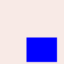

In [13]:
# load image
from transformers import AutoProcessor
processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
example = train_dataset[5]
image = example[0]

text_inputs = processor.tokenizer(
    example[1]["question"], padding=True, return_tensors="pt"
)
question = example[1]['question']

text = f"Question: {question} Answer:"
print(question)
image

In [14]:
inputs = processor(images=image, text=text, return_tensors="pt").to('cuda', torch.float16)

In [15]:
# prepare image for the model
import torch
inputs = processor(images=image, text=text, return_tensors="pt").to('cuda', torch.float32).to('cuda', torch.float16)
pixel_values = inputs.pixel_values

model.to('cuda')
# generated_ids = model.generate(pixel_values, max_length=25)
generated_ids = model.generate(**inputs)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

 yes.


In [16]:
trainer.validate(model_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(

Validation: |          | 0/? [00:00<?, ?it/s]

==================Dataset batch: 0/1==================
Question: what is the blue shape?
Prediction: 
Answer: rectangle
Question: what color is the shape?
Prediction: 
Answer: blue
Question: does the image contain a rectangle?
Prediction: 
Answer: yes
Question: is there a triangle in the image?
Prediction: 
Answer: no
Question: is there a black shape?
Prediction: 
Answer: no
Question: does the image not contain a gray shape?
Prediction:  yes.
Answer: yes
Question: is there a red shape in the image?
Prediction:  no.
Answer: no
Question: does the image not contain a red shape?
Prediction:  yes.
Answer: yes
accuracy: 0.0
f1score: 0.0
WUP Measure: 0.0 


val_bertscore_f1: 0.35249989479780197 




==================Dataset batch: 1/1==================
Question: is there not a blue shape?
Prediction: 
Answer: no
Question: is there not a blue shape in the image?
Prediction:  no.
Answer: no
accuracy: 0.0
f1score: 0.0
WUP Measure: 0.0 


val_bertscore_f1: 0.47624924778938293 




┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         accuracy          │            0.0            │
│          f1score          │            0.0            │
│     val_bertscore_f1      │    0.41437458992004395    │
│        wup_measure        │            0.0            │
└───────────────────────────┴───────────────────────────┘

[{'accuracy': 0.0,
  'f1score': 0.0,
  'wup_measure': 0.0,
  'val_bertscore_f1': 0.41437458992004395}]